# Texture Synthesis with Spatial Generative Adversarial Networks

[Paper](https://arxiv.org/pdf/1611.08207v2.pdf)
[Sample implementation](https://github.com/ubergmann/spatial_gan)


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io

In [2]:
BATCH_SIZE = 16
OUTPUT_WIDTH, OUTPUT_HEIGHT = (128, 128)
R = 16
Z_WIDTH, Z_HEIGHT = (OUTPUT_WIDTH / R, OUTPUT_HEIGHT / R)
Z_DEPTH = 20

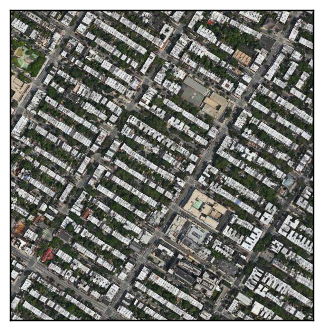

In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/bk.png')
imshow_multi([image])


In [4]:
def _phase_shift(I, r):
    # Helper function with main phase shift operation
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (bsize, a, b, r, r))
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
    X = tf.split(1, a, X)  # a, [bsize, b, r, r]
    X = tf.concat(2, [tf.squeeze(x) for x in X])  # bsize, b, a*r, r
    X = tf.split(1, b, X)  # b, [bsize, a*r, r]
    X = tf.concat(2, [tf.squeeze(x) for x in X])  #
    bsize, a*r, b*r
    return tf.reshape(X, (bsize, a*r, b*r, 1))

def PS(X, r, color=False):
    # Main OP that you can arbitrarily use in you tensorflow code
    if color:
        Xc = tf.split(3, 3, X)
        X = tf.concat(3, [_phase_shift(x, r) for x in Xc])
    else:
        X = _phase_shift(X, r)
    return X

In [5]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.1
    return tf.maximum(alpha*x, x)

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')
    
def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def create_conv(input, out_channels, patch_size=5, stride=1, use_relu=True, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                           shape=[out_channels])
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        activation = lrelu(conv + b) if use_relu else conv + b
        return activation

def create_deconv(input, out_channels, patch_size=5, stride=1, use_relu=True, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                            shape=[out_channels])

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        activation = lrelu(deconv + b) if use_relu else deconv + b
        return activation


In [6]:
source_image = tf.constant(image, tf.float32)
def rand_crop(): return tf.random_crop(source_image, [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3])
real_textures = [rand_crop() for _ in xrange(BATCH_SIZE)]

def generator(noise):
    with tf.variable_scope('generator'):
        image = noise
        # strides must multiply to R (16)
        layers = [128, 64, 32, 3]
        for i, channels in enumerate(layers):
            is_last_layer = i == len(layers)-1
            image = create_deconv(image, 
                                  channels, 
                                  patch_size=5, 
                                  stride=2, 
                                  name='deconv'+str(i), 
                                  use_relu=(not is_last_layer))
            if not is_last_layer:
                image = create_batch_norm(image, name='bn'+str(i))
        assert [d.value for d in image.get_shape()[1:]] == [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]
        return image

def discriminator(textures):
    # input: [BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, 3] textures
    # output: [BATCH_SIZE, Z_WIDTH, Z_HEIGHT, 2]
    #  where the last dim is the logit probability of this texture being real
    with tf.variable_scope('discriminator'):
        image = textures
        # some big convolutional layers:
        layers = [128, 64, 32, 2]
        for i, channels in enumerate(layers):
            is_last_layer = i == len(layers) - 1
            image = create_conv(image, channels, stride=2, patch_size=5, name='conv'+str(i))
            # image = create_avg_pool(image)
            if not is_last_layer:
                image = create_batch_norm(image, name='bn'+str(i))   
        # a couple 1x1 convolutions:
        # for i, channels in enumerate([2]):
        #     image = create_conv(image, channels, stride=1, patch_size=1, name='1x1conv'+str(i))
        assert [d.value for d in image.get_shape()[1:]] == [Z_WIDTH, Z_HEIGHT, 2]
        return image

scopename = '1'
with tf.variable_scope(scopename):

    noise = tf.random_normal([BATCH_SIZE, Z_WIDTH, Z_HEIGHT, Z_DEPTH])
    synthetic_textures = generator(noise)

    disc_input = tf.concat(0, [real_textures, synthetic_textures])
    disc_target = tf.concat(0, [tf.ones([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32), tf.zeros([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)])
    
    disc_output = discriminator(disc_input)
    discriminator_loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(disc_output, disc_target))

    disc_guess = tf.argmax(disc_output, 3)
    disc_correct = tf.equal(tf.cast(disc_guess, tf.int32), disc_target)
    disc_accuracy = tf.reduce_mean(tf.cast(disc_correct, tf.float32))

    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/discriminator')
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/generator')

    global_step = tf.contrib.framework.get_or_create_global_step()

    train_gen = tf.train.AdamOptimizer(0.0004, beta1=0.5).minimize(-discriminator_loss, global_step=global_step, var_list=gen_vars)
    train_disc = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(discriminator_loss, global_step=global_step, var_list=disc_vars)


In [7]:
session = tf.InteractiveSession()

save_path = 'models/sgan128-medium'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

import os
saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Did not restore from checkpoint


Step: 10, loss: 864.938998413, disc accuracy: 0.83486328125
Step: 20, loss: 197.84725647, disc accuracy: 0.97158203125


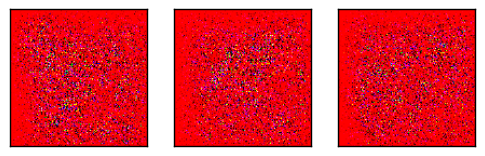

Step: 30, loss: 682.836825562, disc accuracy: 0.88310546875
Step: 40, loss: 2181.03516846, disc accuracy: 0.8068359375


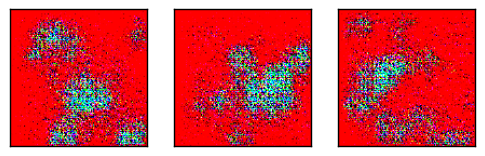

Step: 50, loss: 2456.78612061, disc accuracy: 0.80517578125
Saved
Step: 60, loss: 1244.71696167, disc accuracy: 0.843798828125


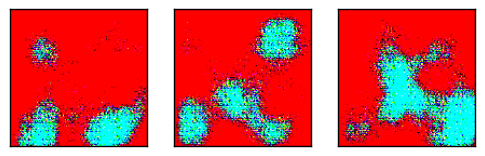

Step: 70, loss: 2059.15316162, disc accuracy: 0.809912109375
Step: 80, loss: 2316.00936279, disc accuracy: 0.7951171875


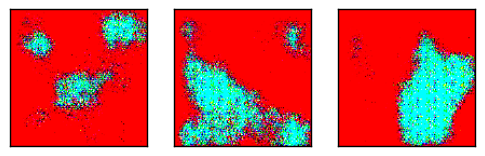

Step: 90, loss: 1453.3786377, disc accuracy: 0.800732421875
Step: 100, loss: 1220.94196167, disc accuracy: 0.79462890625


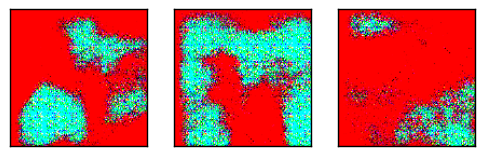

Saved
Step: 110, loss: 680.871746826, disc accuracy: 0.808544921875
Step: 120, loss: 682.684063721, disc accuracy: 0.798046875


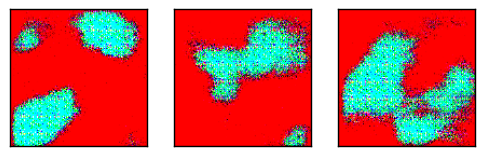

Step: 130, loss: 557.764355469, disc accuracy: 0.813330078125
Step: 140, loss: 628.27364502, disc accuracy: 0.8017578125


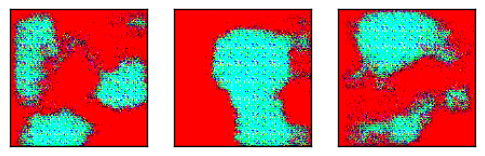

Step: 150, loss: 620.488598633, disc accuracy: 0.8083984375
Saved
Step: 160, loss: 587.805169678, disc accuracy: 0.823193359375


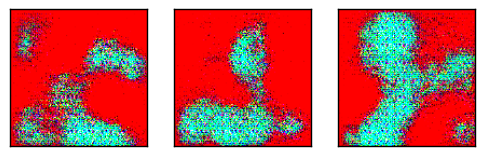

Step: 170, loss: 690.389642334, disc accuracy: 0.821875
Step: 180, loss: 1123.93026123, disc accuracy: 0.788134765625


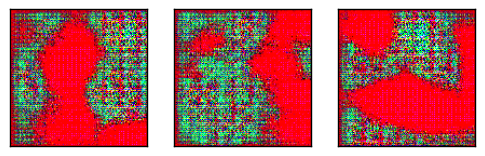

Step: 190, loss: 686.790258789, disc accuracy: 0.833154296875
Step: 200, loss: 760.916143799, disc accuracy: 0.83125


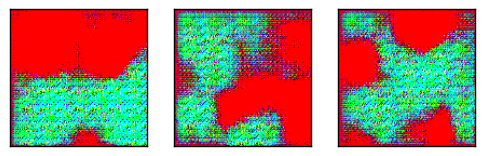

Saved
Step: 210, loss: 790.621160889, disc accuracy: 0.840283203125
Step: 220, loss: 894.842126465, disc accuracy: 0.82880859375


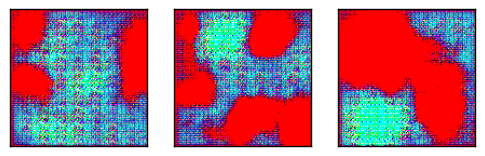

Step: 230, loss: 917.704199219, disc accuracy: 0.80986328125
Step: 240, loss: 979.519488525, disc accuracy: 0.80107421875


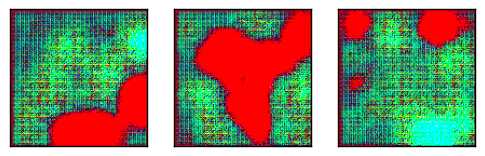

Step: 250, loss: 789.127603149, disc accuracy: 0.844873046875
Saved
Step: 260, loss: 946.002603149, disc accuracy: 0.818408203125


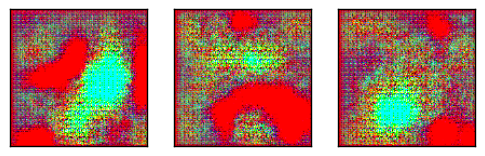

Step: 270, loss: 859.563031006, disc accuracy: 0.819384765625
Step: 280, loss: 1000.2225769, disc accuracy: 0.797216796875


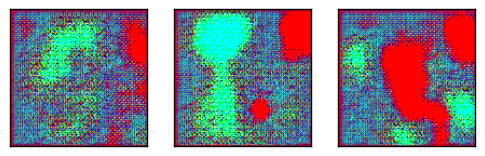

Step: 290, loss: 870.344671631, disc accuracy: 0.808935546875
Step: 300, loss: 821.104962158, disc accuracy: 0.818017578125


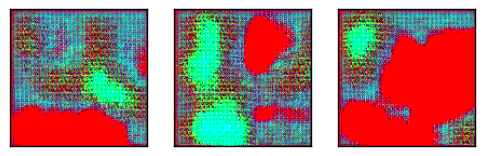

Saved
Step: 310, loss: 903.036499023, disc accuracy: 0.79990234375
Step: 320, loss: 945.426025391, disc accuracy: 0.78779296875


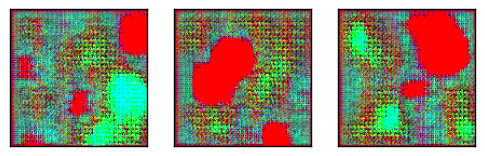

Step: 330, loss: 861.305517578, disc accuracy: 0.800146484375
Step: 340, loss: 895.502484131, disc accuracy: 0.79521484375


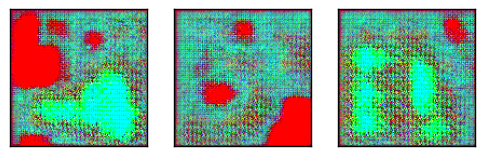

ResourceExhaustedError: OOM when allocating tensor with shape[32,128,64,64]
	 [[Node: 1/gradients_1/1/discriminator/conv1/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](1/gradients_1/1/discriminator/conv1/Conv2D_grad/Shape, 1/discriminator/conv1/w/read, 1/gradients_1/1/discriminator/conv1/add_grad/tuple/control_dependency)]]
	 [[Node: 1/Adam_1/update/_83608 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1123_1/Adam_1/update", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'1/gradients_1/1/discriminator/conv1/Conv2D_grad/Conv2DBackpropInput', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/nparrott/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/nparrott/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/nparrott/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/nparrott/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nparrott/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/nparrott/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/nparrott/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/nparrott/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nparrott/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nparrott/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nparrott/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nparrott/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-16ff20912348>", line 65, in <module>
    train_disc = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(discriminator_loss, global_step=global_step, var_list=disc_vars)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 269, in minimize
    grad_loss=grad_loss)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 335, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_grad.py", line 342, in _Conv2DGrad
    op.get_attr("data_format")),
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 489, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'1/discriminator/conv1/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/home/nparrott/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-16ff20912348>", line 52, in <module>
    disc_output = discriminator(disc_input)
  File "<ipython-input-6-16ff20912348>", line 33, in discriminator
    image = create_conv(image, channels, stride=2, patch_size=5, name='conv'+str(i))
  File "<ipython-input-5-41b97b80bdfb>", line 27, in create_conv
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,128,64,64]
	 [[Node: 1/gradients_1/1/discriminator/conv1/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](1/gradients_1/1/discriminator/conv1/Conv2D_grad/Shape, 1/discriminator/conv1/w/read, 1/gradients_1/1/discriminator/conv1/add_grad/tuple/control_dependency)]]
	 [[Node: 1/Adam_1/update/_83608 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1123_1/Adam_1/update", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [8]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
losses = []
last_saved_loss = None

while True:
    only_train_gen = len(disc_accuracies) > 0 and avg(disc_accuracies) > 0.8
    only_train_disc = len(disc_accuracies) > 0 and avg(disc_accuracies) < 0.6
    n_gen_runs = 0 if only_train_disc else 1
    n_disc_runs = 0 if only_train_gen else 1
    examples_ = None
        
    for _ in range(n_gen_runs):
        examples_, disc_acc_, step_, loss_, _ = session.run([synthetic_textures[:3], disc_accuracy, global_step, discriminator_loss, train_gen])
        losses.append(loss_)
        disc_accuracies.append(disc_acc_)
    
    for _ in range(n_disc_runs):
        feed = {dropout_keep_prob: 0.5}
        examples_, disc_acc_, step_, loss_, _ = session.run([synthetic_textures[:3], disc_accuracy, global_step, discriminator_loss, train_disc], feed_dict=feed)
        losses.append(loss_)
        disc_accuracies.append(disc_acc_)
    
    step_rounded = int(step_ / 2) * 2
    if step_rounded % 10 == 0:
        print "Step: {}, loss: {}, disc accuracy: {}".format(step_rounded, avg(losses), avg(disc_accuracies))
        
        if step_rounded % 20 == 0 and examples_ is not None:
            imshow_multi(list(examples_))
        
        if step_rounded % 50 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_rounded)
                print 'Saved'
            else:
                pass
                # print 'Loss did not decrease from previous save, so not saving'
        
        disc_accuracies = []
        losses = []


In [ ]:
%matplotlib inline
def generate_sample():
    textures, real = session.run([synthetic_textures, real_textures])
    imshow_multi(list(np.clip(textures[:3], 0, 1)) + list(real[:1]))
    return to_pil(textures[0])
generate_sample()